In [1]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data 


In [2]:
mkts=get_market_list()

In [3]:
df=pd.DataFrame()
for m in mkts:
    try:
        df[m]=get_timeseries(m)
    except:
        print m

In [4]:
FundAUM=1e6
curr_px=get_most_liquid_price(mkts)

# Idea is to add two different look back signals to the same model

* In theory every level should be vol scaled to ensure equal risk allocation (signal, market, and fund level as we don't have sectors here)
* Need to get the scaling factor correct.  Problably best to get the scaling factor correct in signal space then 

In [33]:
short_lookback=20
long_lookback=40

In [34]:
pos=tsmom_daily(df[mkts],short_lookback)
pnl_short=calc_pnl_wc(pos,df[mkts])
pos=tsmom_daily(df[mkts],long_lookback)
pnl_long=calc_pnl_wc(pos,df[mkts])

model.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=40,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)


In [35]:
t=pd.DataFrame()
t['Short']=pnl_short.sum(axis=1)
t['Long']=pnl_long.sum(axis=1)
t['Combined']=(pnl_short*.5+pnl_long*.5).sum(axis=1)
calc_Sharpe(t)

Short       1.192710
Long        1.122695
Combined    1.233271
dtype: float64

In [36]:
combined_pnl=(pnl_short*.5+pnl_long*.5)
scaling_factor=calc_scaling_factor(combined_pnl)

# Then add to position space models

In [37]:
s_short=tsmom_daily_signal(df,short_lookback)
s_long=tsmom_daily_signal(df,long_lookback)

model.py:16: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=40,center=False).mean()
  signal=pd.rolling_mean(data,signal_lookback)


In [38]:
s_combined = (s_short*.5+s_long*.5)

In [39]:
lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)
PNL = calc_pnl_position_wc(lots,df,curr_px)

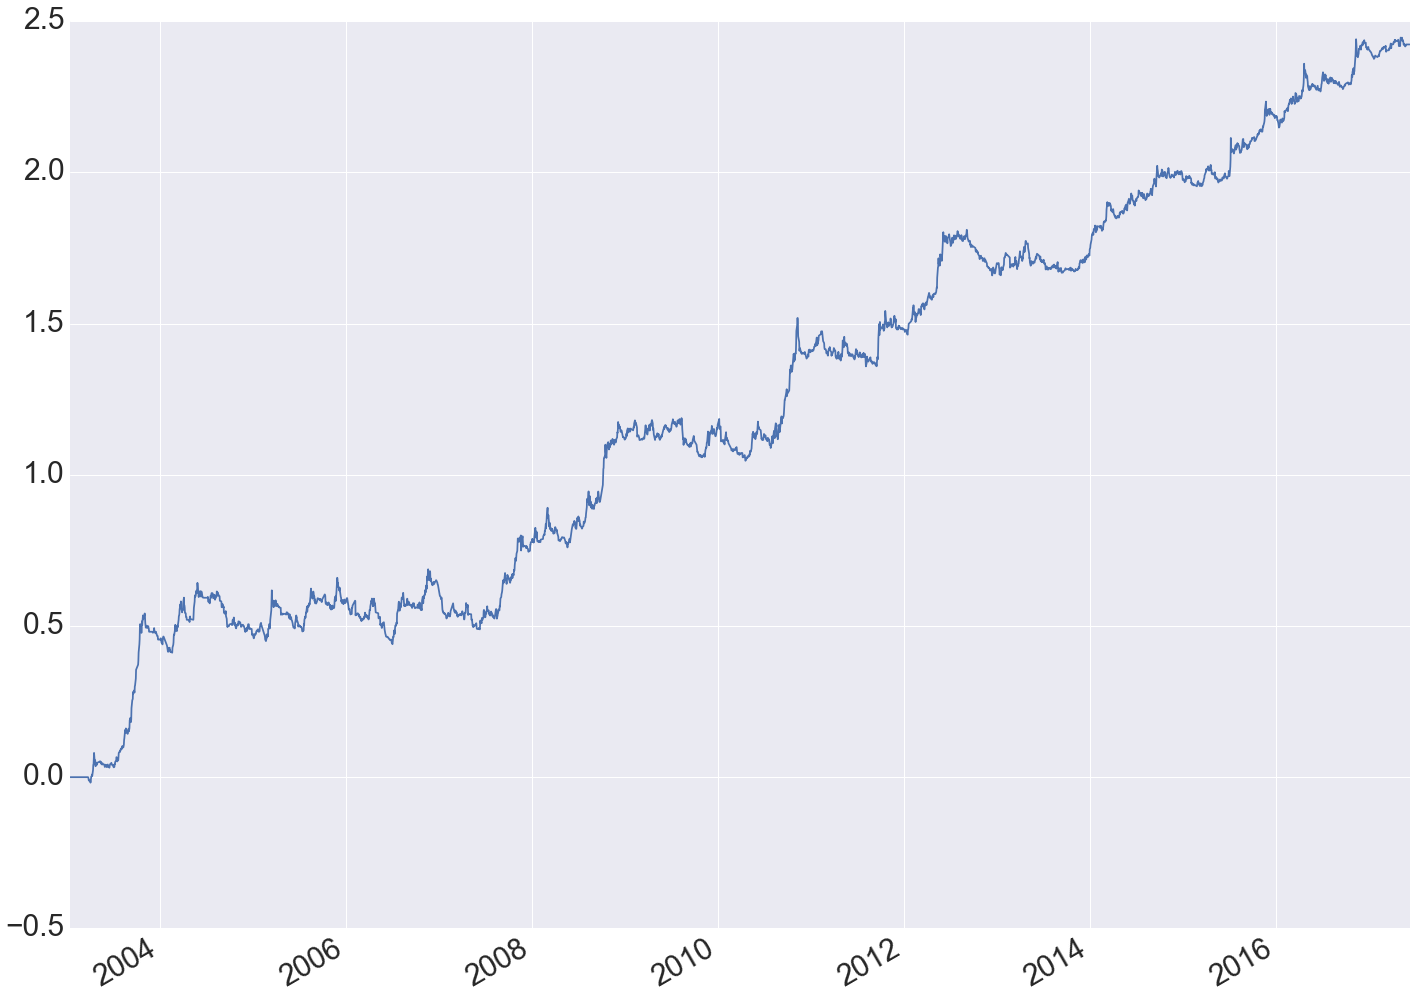

In [40]:
(PNL.sum(axis=1)/FundAUM).cumsum().plot()

In [41]:
calc_Sharpe((PNL.sum(axis=1)/FundAUM))

1.1493275047318199

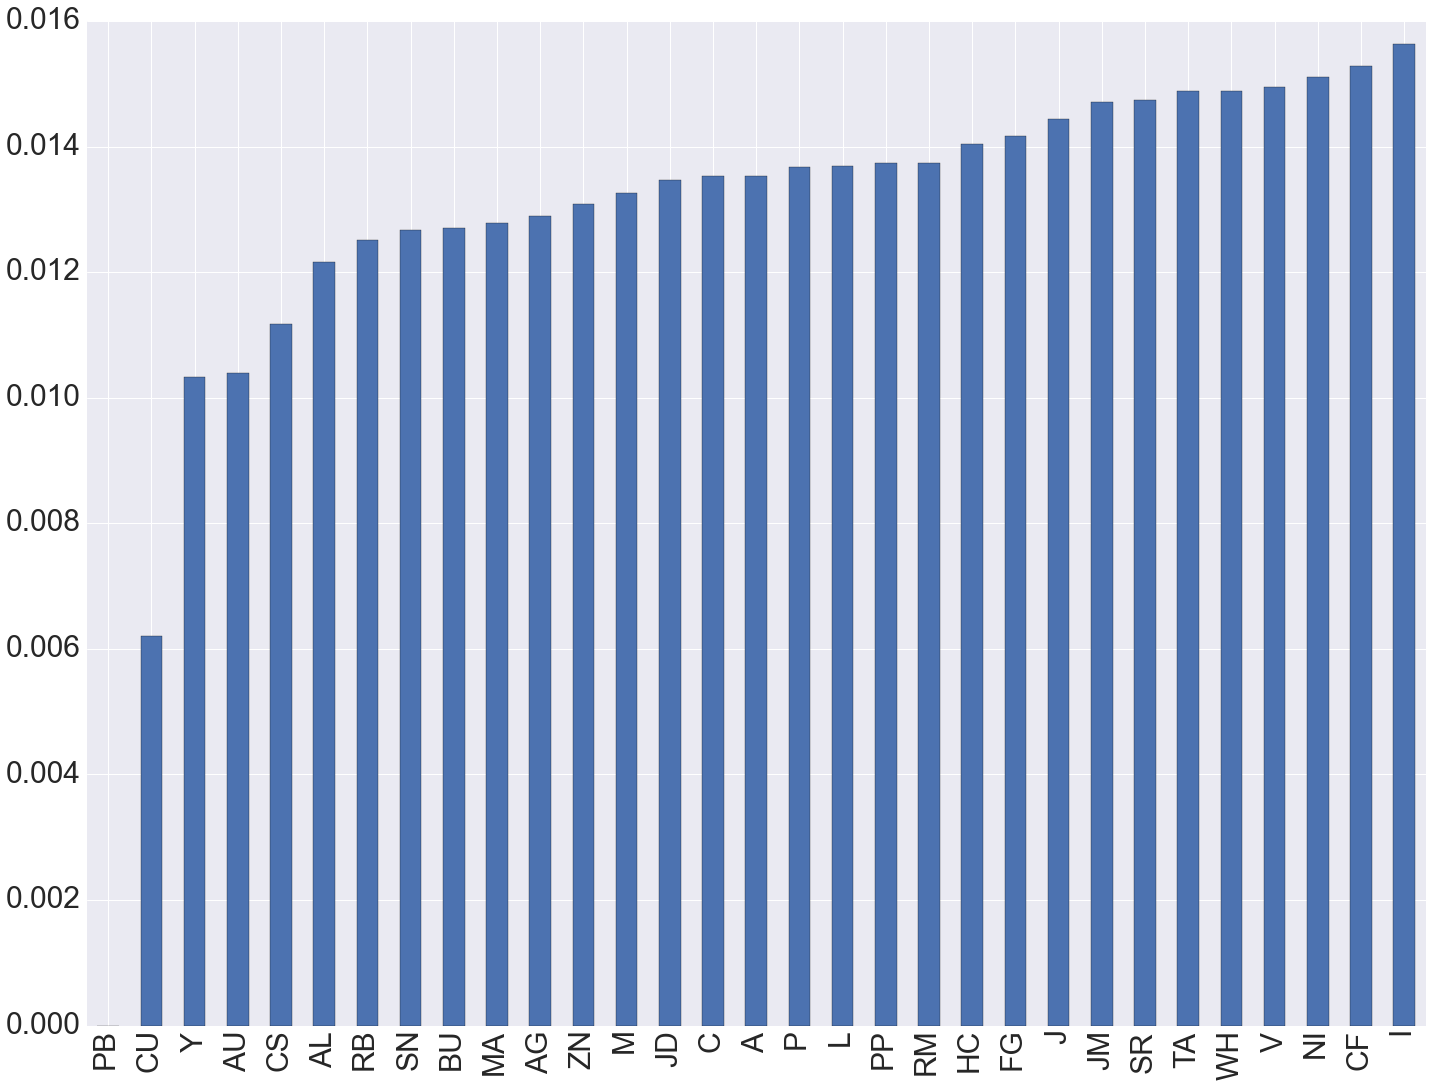

In [46]:
((PNL/FundAUM)['2014':].std().dropna()*16).sort_values().plot(kind='bar')

# Then add to position space models

* While it does hit the vol target I still worry there are isseus with not being equal weight at different levels